# Implementing k-means

First we create the dataset. It will have 1500 samples and we want to use k-means to detect clusters in this dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

np.random.seed(0)

n_samples = 1500
X, y = datasets.make_blobs(n_samples=n_samples, random_state=8)

In [2]:
print(X)
print(y)

[[  5.86749807   8.17715188]
 [  5.61369982   9.93295527]
 [  7.22508428  10.44886194]
 ..., 
 [  7.73674097  10.82855388]
 [ -4.61701094  -9.64855983]
 [ -3.48640175  -9.25766922]]
[0 0 0 ..., 0 2 2]


The above objects are numpy multi-arrays and unfortunately we don't have numpy on the cluster. However, there is a way around this: we need to turn the numpy array into a list of lists, and Spark can work with this format just as well.

In [3]:
X = X.tolist()
y = y.tolist()

To start the k-means calculation we pick three centroids - randomly, so in this case we select the first three points in the dataset.

In [4]:
k = 3
centroids = X[:k]
print(centroids)

[[5.867498067335642, 8.177151880030342], [5.613699815229969, 9.932955265811792], [7.225084277857703, 10.448861938921507]]


Now we start using Spark. The first operation is the creation of a "Resilient Distributed Dataset" (RDD) which means distributing the data to the available nodes. This could be any size of underlying cluster - the user doesn't see the details.

Note that this is just a demo and normally the dataset would be available on the compute nodes.

In [5]:
rdd = sc.parallelize(X)
rdd.cache()

ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:475

We tell Spark to cache this dataset because k-means is an iterative algorithm and we will scan through the data many times. (In this case, the dataset is so small that it will be easily kept in memory. However, if necessary, Spark can spill to disk if the dataset grows too large.)

Let's see how many records are in the dataset: Call the function count.

In [6]:
rdd.count()

1500

For the k-means algorithm we need to define a cost function. We will use the squared Euclidean distance which is the "distance" between points.

In [7]:
from math import sqrt
def cost_function(x, y):
    return sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)

We can test the cost function on two random points of the dataset:

In [8]:
cost_function(X[205], X[978])

0.9590304461225516

Now we start the first k-means iteration: For each point in the dataset we calculate the distances to each of the centroids. Then we assign the point to the centroid to which it has the smallest distance.

Spark allows us to do this quite easily: "For each" means we apply the "map" function, and define the output as a lambda. So the following means that each point x is mapped to a tuple with itself (x) as the first element, and the second element is a list of distances to all the centroids.

In [9]:
d = rdd.map(lambda x: (x, [cost_function(x, centroids[i]) for i in range(k)]))

At this point, Spark has not actually "materialised" the dataset so no computations have actually happened because we only applied a "transformation". To kick off the calculation we need to use an "action", for example "take" which returns the first n elements of a dataset. Let's have a look at the first 2 entries that from our mapping.

In [10]:
d.take(2)

[([5.867498067335642, 8.177151880030342],
  [0.0, 1.7740516007978733, 2.646451758613209]),
 ([5.613699815229969, 9.932955265811792],
  [1.7740516007978733, 0.0, 1.6919573226760787])]

Now that we know all the distances we can pick the centroid that have the smallest distance to our point. To do this we map each point to a tuple of itself and the centroid.

In [11]:
assignments = d.map(lambda (x, c): (c.index(min(c)), x))
assignments.take(10)

[(0, [5.867498067335642, 8.177151880030342]),
 (1, [5.613699815229969, 9.932955265811792]),
 (2, [7.225084277857703, 10.448861938921507]),
 (0, [6.76282254631617, 0.6051453524386279]),
 (0, [8.016182400197797, 1.5431470087909844]),
 (0, [8.40185355966284, -0.3734813153278215]),
 (1, [6.5119227666953865, 9.813429020266614]),
 (0, [7.39967960252523, 0.9125888100340231]),
 (0, [-4.984363346491188, -11.422275250728518]),
 (0, [9.888250958231662, 0.9024139190174933])]

In [12]:
assignments.map(lambda (c, a): (c, 1)).reduceByKey(lambda a,b: a+b).collect()

[(0, 1124), (1, 57), (2, 319)]

Actually, Spark has a built-in function that does this directly:

In [13]:
assignments.countByKey()

defaultdict(int, {0: 1124, 1: 57, 2: 319})

Now we start the next iteration: For each cluster we calculate a new centroid as the mean of all points in this cluster. So we first need to separate the clusters.

In [14]:
c0 = assignments.filter(lambda (a, x): a==0).map(lambda (a, x): x)
c1 = assignments.filter(lambda (a, x): a==1).map(lambda (a, x): x)
c2 = assignments.filter(lambda (a, x): a==2).map(lambda (a, x): x)
c0.take(10)

[[5.867498067335642, 8.177151880030342],
 [6.76282254631617, 0.6051453524386279],
 [8.016182400197797, 1.5431470087909844],
 [8.40185355966284, -0.3734813153278215],
 [7.39967960252523, 0.9125888100340231],
 [-4.984363346491188, -11.422275250728518],
 [9.888250958231662, 0.9024139190174933],
 [7.953113720266394, 8.368976644531578],
 [6.108460663453791, 8.233439954433162],
 [-6.668436976547094, -9.3570716767763]]

We now calculate the mean for each cluster and that yields the new centroids.

In [20]:
sum0 = c0.reduce(lambda a,b: (a[0]+b[0],a[1]+b[1]))
print(sum0)
sum1 = c1.reduce(lambda a,b: (a[0]+b[0],a[1]+b[1]))
sum2 = c2.reduce(lambda a,b: (a[0]+b[0],a[1]+b[1]))
print(c0.count())
new_centroids = [[sum0[0]/c0.count(), sum0[1]/c0.count()],
                 [sum1[0]/c1.count(), sum1[1]/c1.count()],
                 [sum2[0]/c2.count(), sum2[1]/c2.count()]]
print(new_centroids)

(1912.08080524043, -3537.7913771300055)
1124
[[1.7011395064416637, -3.147501225204631], [5.8820122167290725, 9.833078699554283], [7.963819894302796, 9.800038704536382]]


Now we use the same method as before to assign the points to their new centroids.

In [21]:
d = rdd.map(lambda x: (x, [cost_function(x, new_centroids[i]) for i in range(k)]))
new_assignments = d.map(lambda (x, c): (c.index(min(c)), x))
new_assignments.take(10)

[(1, [5.867498067335642, 8.177151880030342]),
 (1, [5.613699815229969, 9.932955265811792]),
 (2, [7.225084277857703, 10.448861938921507]),
 (0, [6.76282254631617, 0.6051453524386279]),
 (0, [8.016182400197797, 1.5431470087909844]),
 (0, [8.40185355966284, -0.3734813153278215]),
 (1, [6.5119227666953865, 9.813429020266614]),
 (0, [7.39967960252523, 0.9125888100340231]),
 (0, [-4.984363346491188, -11.422275250728518]),
 (2, [9.888250958231662, 0.9024139190174933])]

And plot the results.

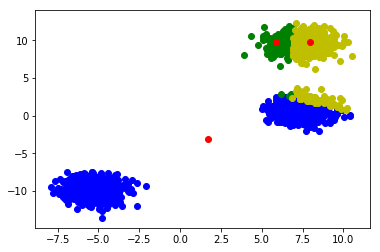

In [22]:
colours = ['b','g','y']
for i in range(k):
    all_assigned = np.array(new_assignments.filter(lambda (a, x): a==i).map(lambda (c, x): x).collect())
    plt.scatter(all_assigned[:,0], all_assigned[:,1], color=colours[i])
    plt.scatter([new_centroids[i][0]], [new_centroids[i][1]], color=['r'])
plt.show()
plt.gcf().clear()